# 2D cross-well tomography
The forward simulation takes the form 

$$
t_j = \int_{\Gamma_j} s(x, y) dl
$$


where $s(x,y) = 1/v(x, y)$ is the slowness (equal to the inverse of the velocity). Note that we will work with $x$ as the first dimension and $y$ as the second dimension.
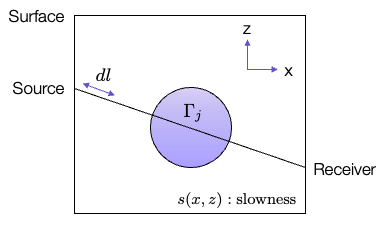

<Q1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import discretize

from SimPEG import seismic

from SimPEG import (
    maps,
    utils,
    survey,
    data,
    data_misfit,
    directives,
    optimization,
    regularization,
    inverse_problem,
    inversion,
)


## set up a mesh

In [2]:
extent_x = 200
extent_y = 400

dx = 10
dy = 10

nx = int(np.ceil(extent_x / dx))
ny = int(np.ceil(extent_y / dy))

hx = np.ones(nx) * dx
hy = np.ones(ny) * dy
mesh = discretize.TensorMesh([hx, hy])

# Set up survey

In [3]:
n_src = 10
y_src = np.linspace(dy/2, extent_y-dy/2, n_src)

source_locations = np.c_[np.zeros_like(y_src), y_src]
receiver_locations = np.c_[np.zeros_like(y_src) + mesh.nodes_x[-1], y_src]

rx = survey.BaseRx(receiver_locations)

# source_list = [
#     survey.BaseSrc(
#         location=source_locations[i, :], receiver_list=[rx]
#     )
#     for i in range(y_src.size)
# ]

source_list = []

for i in range(y_src.size):
    source_list.append(
        survey.BaseSrc(
            location=source_locations[i, :], receiver_list=[rx]
        )
    )
tomo_survey = seismic.straight_ray_tomography.Survey(source_list)


## build model

In [4]:
v0 = 1000
v1 = 2500
block_x = np.r_[60, 140]
block_y = np.r_[180, 220]

velocity_model = v0*np.ones(mesh.n_cells)
background_velocity = velocity_model.copy()

In [5]:
def add_block(velocity_model, block_x, block_y, value): 
    inds_block = (
        (mesh.cell_centers[:, 0] > block_x.min()) &
        (mesh.cell_centers[:, 0] < block_x.max()) &
        (mesh.cell_centers[:, 1] > block_y.min()) &
        (mesh.cell_centers[:, 1] < block_y.max()) 
    ) 

    velocity_model[inds_block] = value
    
    return velocity_model
    
velocity_model = add_block(velocity_model, block_x, block_y, v1) 

true_slowness_model = 1/velocity_model
background_slowness_model = 1/background_velocity

<Axes: title={'center': 'True Model'}, xlabel='x', ylabel='y'>

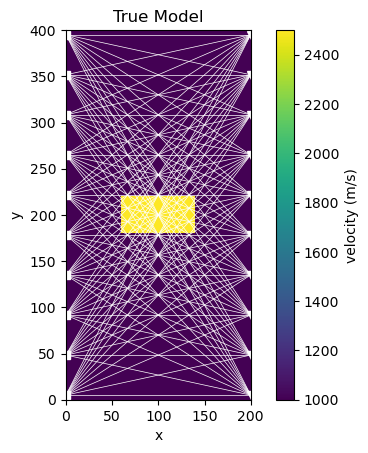

In [6]:
def plot_model_survey(
    mesh, model, source_locations, receiver_locations, ax=None, 
    show_raypaths=True, vmin=None, vmax=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1)
    
    cb = plt.colorbar(
        mesh.plot_image(model, ax=ax, pcolor_opts={"vmin":vmin, "vmax":vmax})[0], 
        ax=ax
    )
    
    cb.set_label("velocity (m/s)")
    
    ax.set_aspect(1)

    ax.plot(source_locations[:, 0], source_locations[:, 1], "ws", ms=6)
    ax.plot(receiver_locations[:, 0], receiver_locations[:, 1], "wv", ms=6)
    ax.set_title("True Model")
    if show_raypaths is True: 
        for i in range(source_locations.shape[0]):
            for j in range(receiver_locations.shape[0]):
                ax.plot(
                    np.r_[source_locations[i, 0], receiver_locations[j, 0]],
                    np.r_[source_locations[i, 1], receiver_locations[j, 1]],
                    color="w",
                    linewidth=0.5
                )
    return ax
plot_model_survey(
    mesh, velocity_model, source_locations, receiver_locations,
    show_raypaths=True
)

## simulate data

In [7]:
simulation = seismic.straight_ray_tomography.Simulation(
    mesh=mesh,
    survey=tomo_survey,
    slownessMap=maps.IdentityMap(mesh),
)

In [8]:
#Predit data
background_data = simulation.dpred(background_slowness_model)
clean_data = simulation.dpred(true_slowness_model)

## plot the simulated data
# Q1a
Add a block near the center of the survey region with a different velocity. The velocity can be smaller or larger (use a difference of at least a factor of 2). Plot the true model, the simulated data in a homogeneous backgroud, the data with the block and the difference between the data with and without the block. Don't add any noise yet.

In [9]:
levels = np.linspace(0.10, 0.50, 21)
contours = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

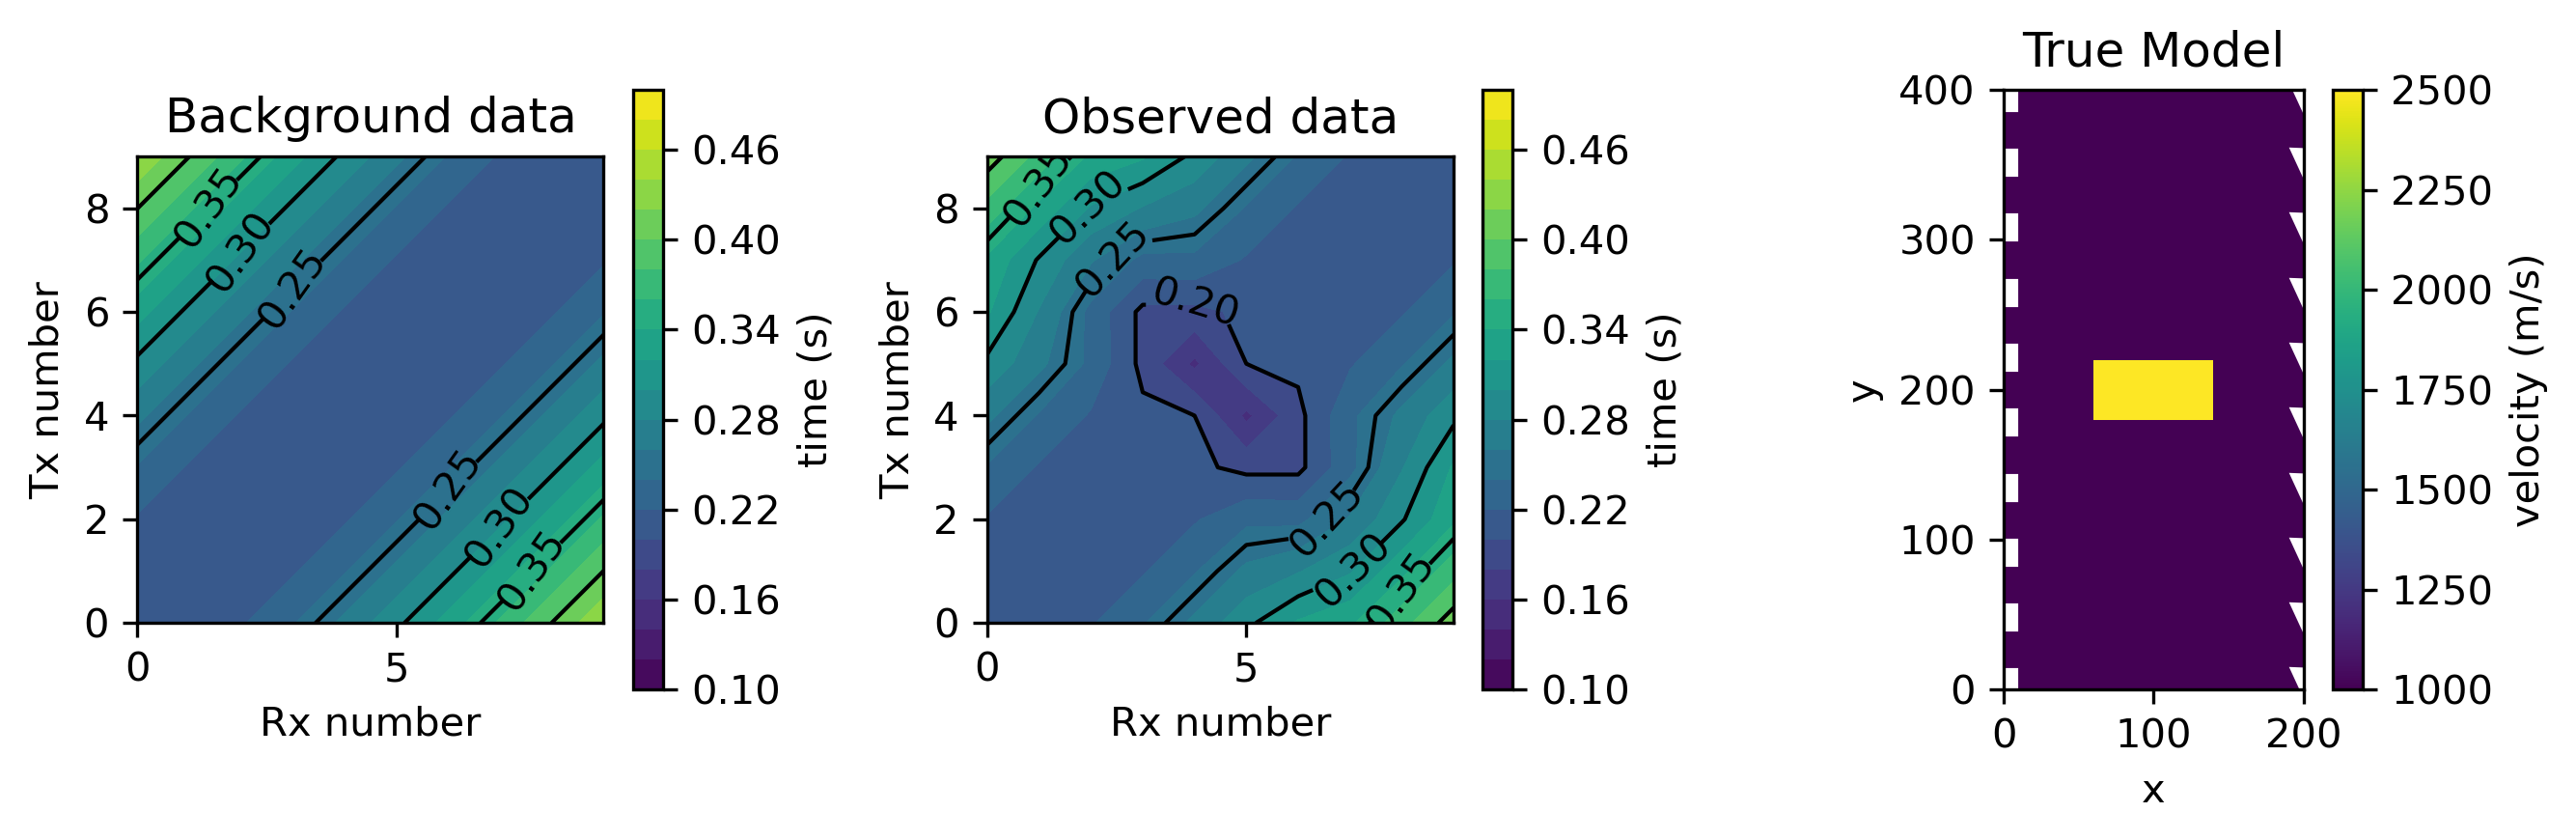

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
plot_model_survey(
    mesh, velocity_model, source_locations, receiver_locations,
    show_raypaths=False, ax = ax[2]
)

def plot_model(ax, dplot, title,contour=True):
    if contour is True:
        cb = plt.colorbar(ax.contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))
        CS = ax.contour(
                dplot.reshape(n_src, n_src, order="F"),
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax.clabel(CS, inline=True, fontsize=10)
        ax.set_aspect(1)
    else:
        cb = plt.colorbar(ax.contourf(dplot.reshape(n_src, n_src, order="F")))

    ax.set_xlabel("Rx number")
    ax.set_ylabel("Tx number")
    cb.set_label("time (s)")
    ax.set_title(title)

for i, dplot in enumerate([background_data, clean_data]):
    plot_model(ax[i], dplot, ["Background data", "Observed data"][i])
plt.tight_layout()
plt.tight_layout()

# Q1b.
First, lets convince ourselves that the forward simulation is working properly. By looking at the data for the uniform 1000 m/s background, can you demonstrate that the forward simulation is working properly? You might want to test a couple of different uniform backgrounds to convince yourself.

Ans
Given a background velocity of 1000 m/s we expect the straight-ray traveltime to be 0.2s. Similarly, for background velocity of 2000 m/s and 500 m/s we expect the traveltime to be 0.1s and 0.4s respectively. We can test this by simulating the data for these three background velocities and plotting the data as shown below.

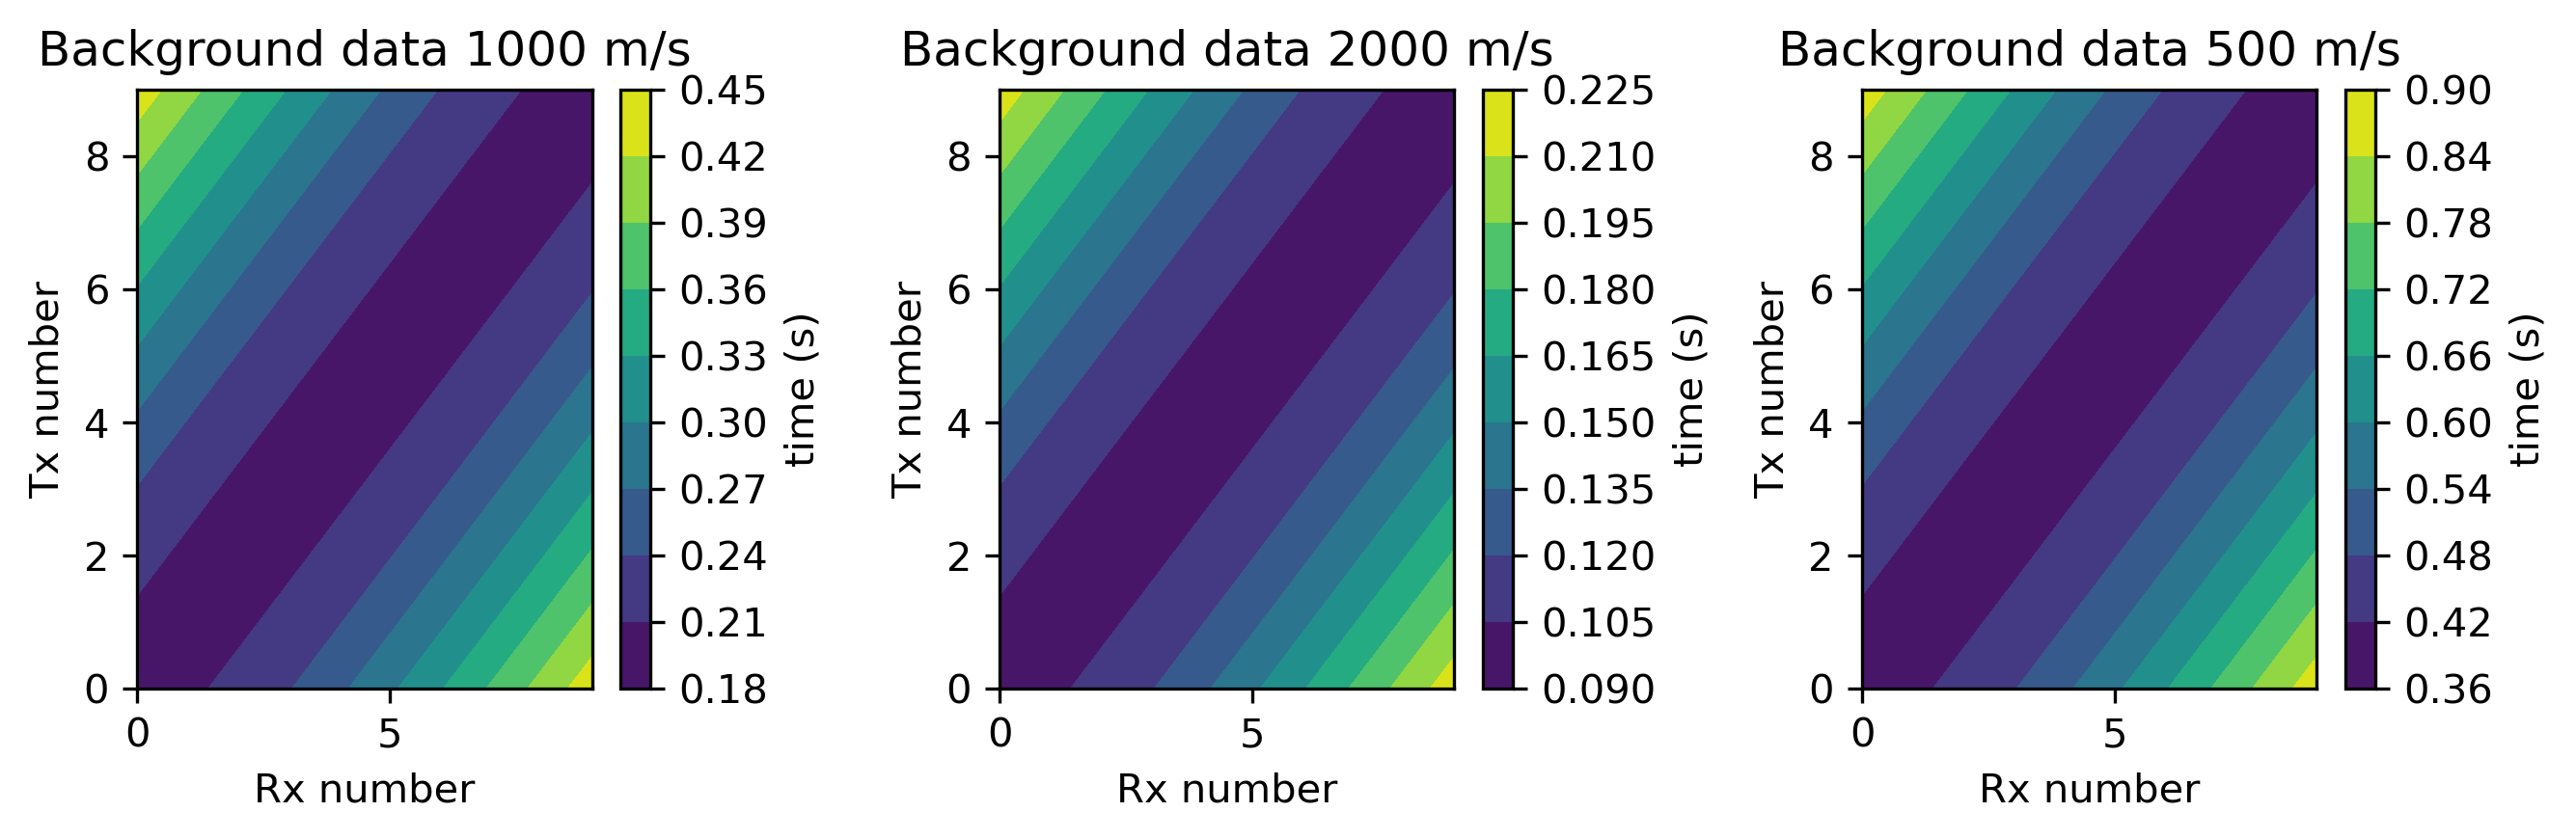

In [11]:
background_velocity_test = [1000,2000,500]
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
for i in range(3):
    background_data_test = simulation.dpred(1/background_velocity_test[i]*np.ones(mesh.n_cells))
    plot_model(ax[i], background_data_test, f"Background data {background_velocity_test[i]} m/s",contour=False)
plt.tight_layout()

# Q1.c
What is the maximum difference between the model with and without the block? What is that difference as a percentage?

Max difference: 4.91e-02 s
Max difference percent: 11.94%


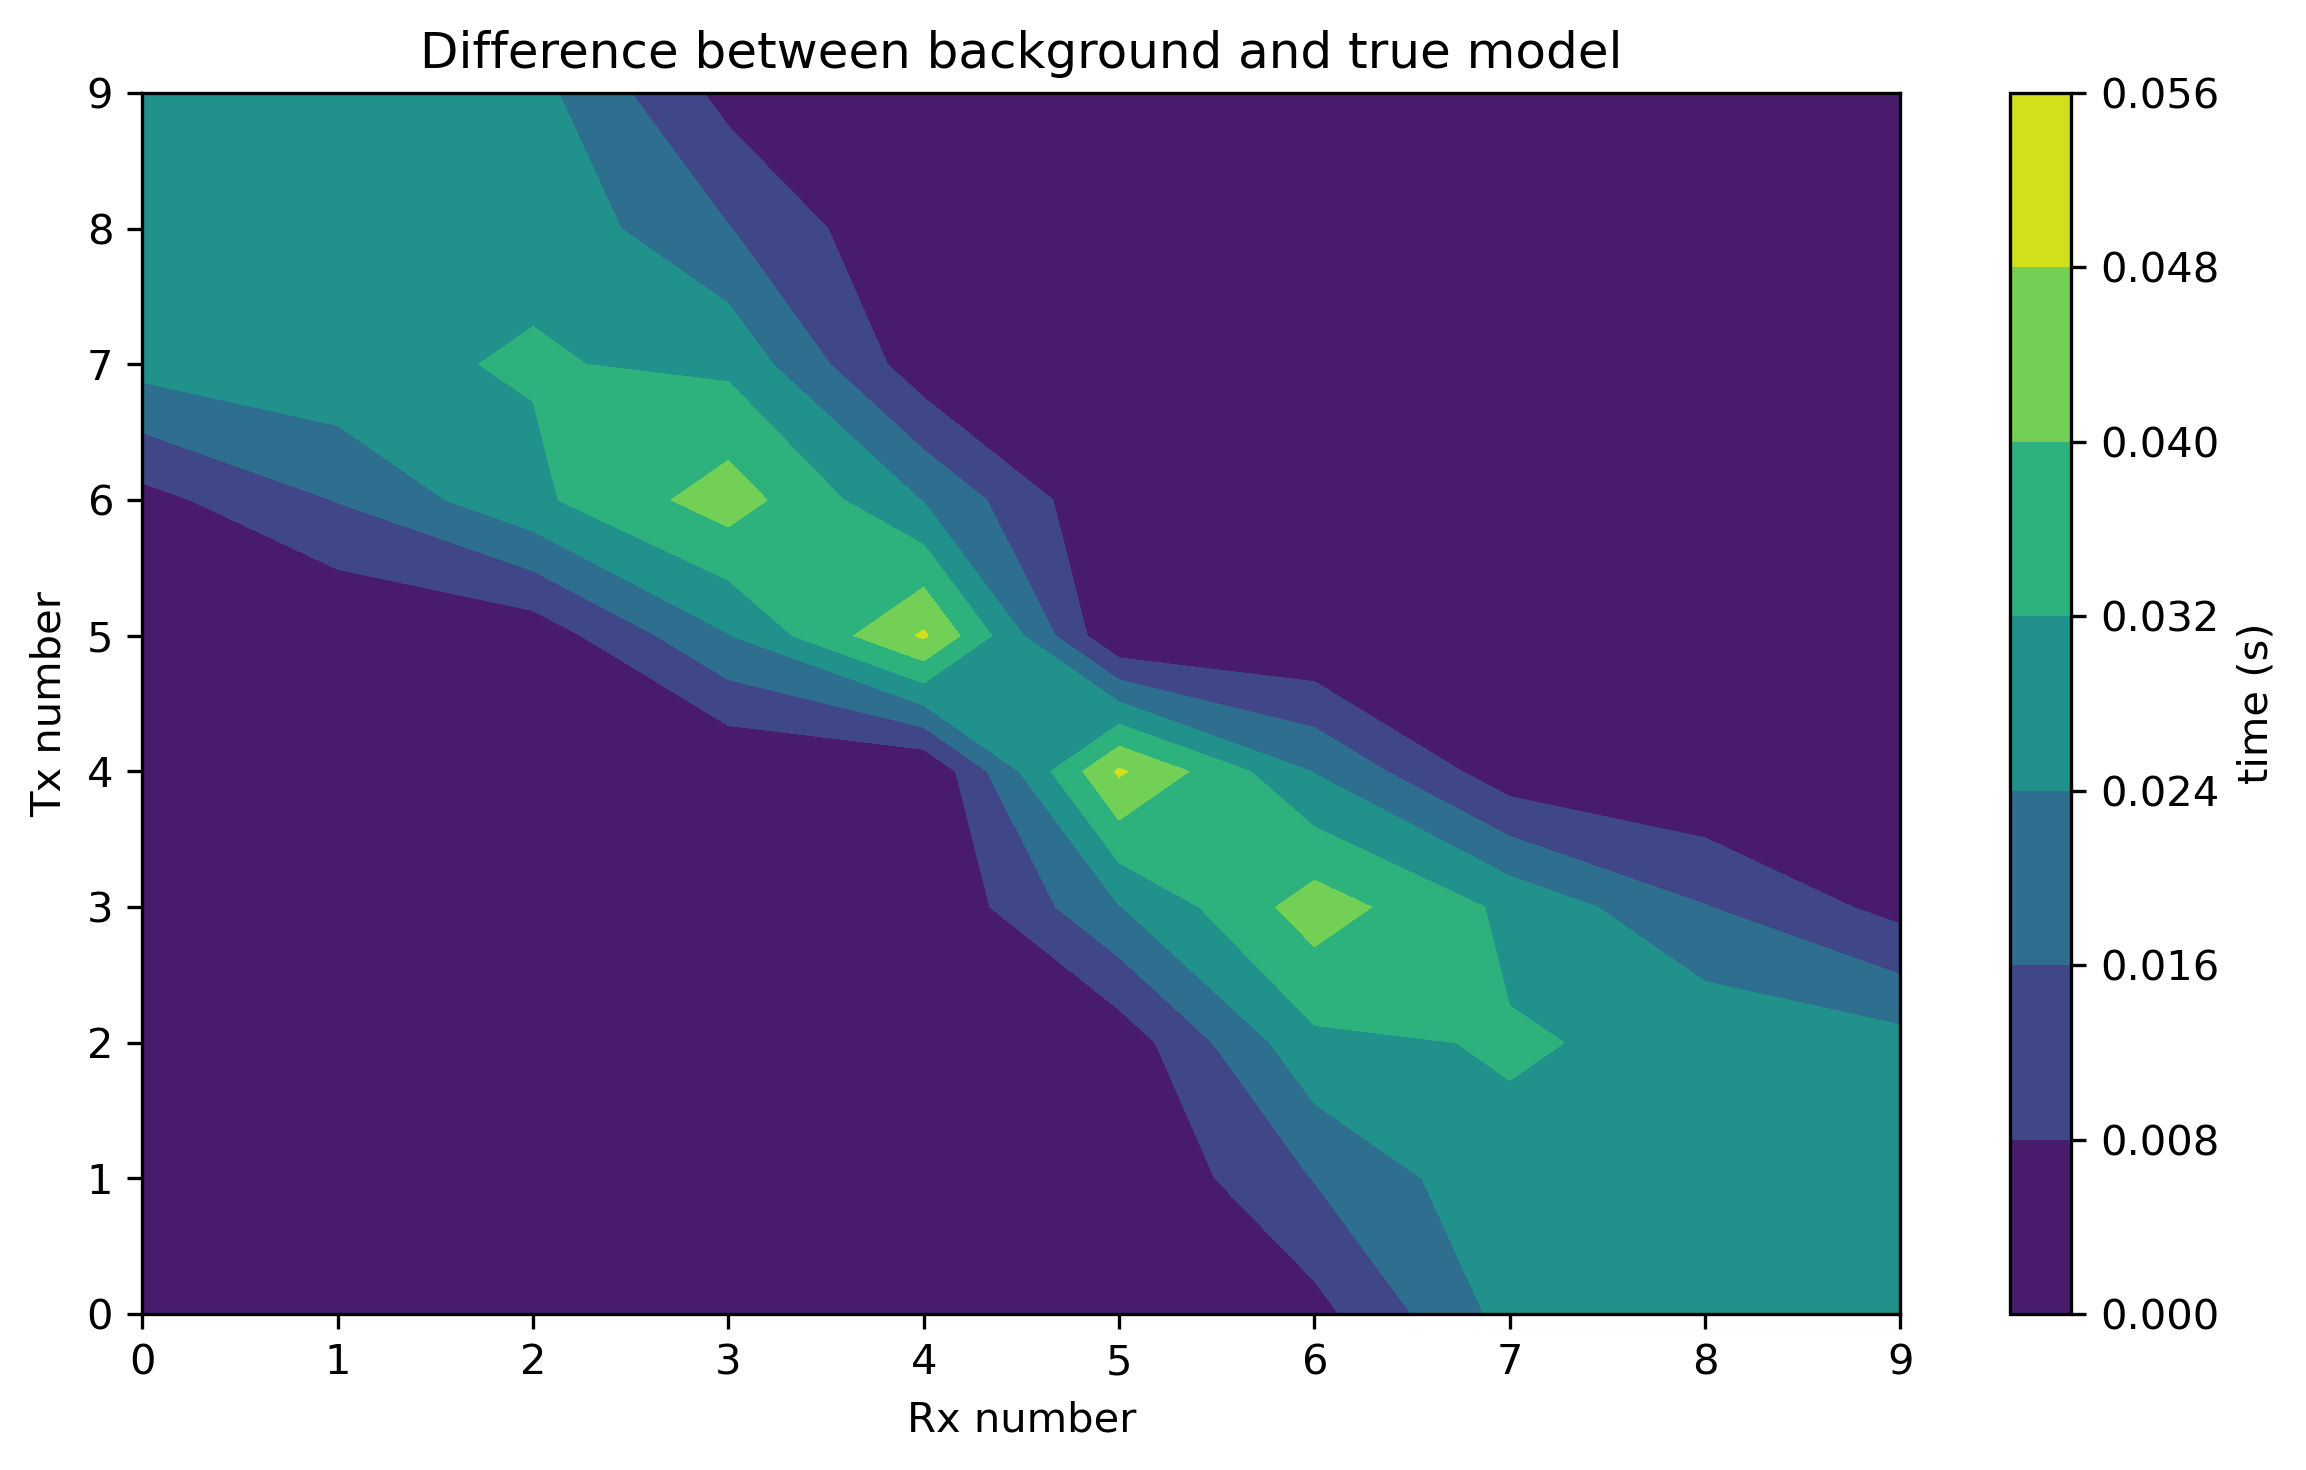

In [12]:
max_diff = np.max(np.abs(background_data - clean_data))
max_diff_percent = max_diff/np.max(clean_data)*100
print(f"Max difference: {max_diff:.2e} s\nMax difference percent: {max_diff_percent:.2f}%")
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300)
plot_model(ax, np.abs(clean_data - background_data), "Difference between background and true model",contour=False)
plt.tight_layout()

# Q1.d
Now we will examine detectability of a target. Let's explore what happens when you add noise. Generate plots for a couple of choices of noise levels, where the noise is added as a percentage (e.g. `np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)`, where percentage error is `100% * relative_error`). At what noise level do you no longer have confidence that you can see the target?

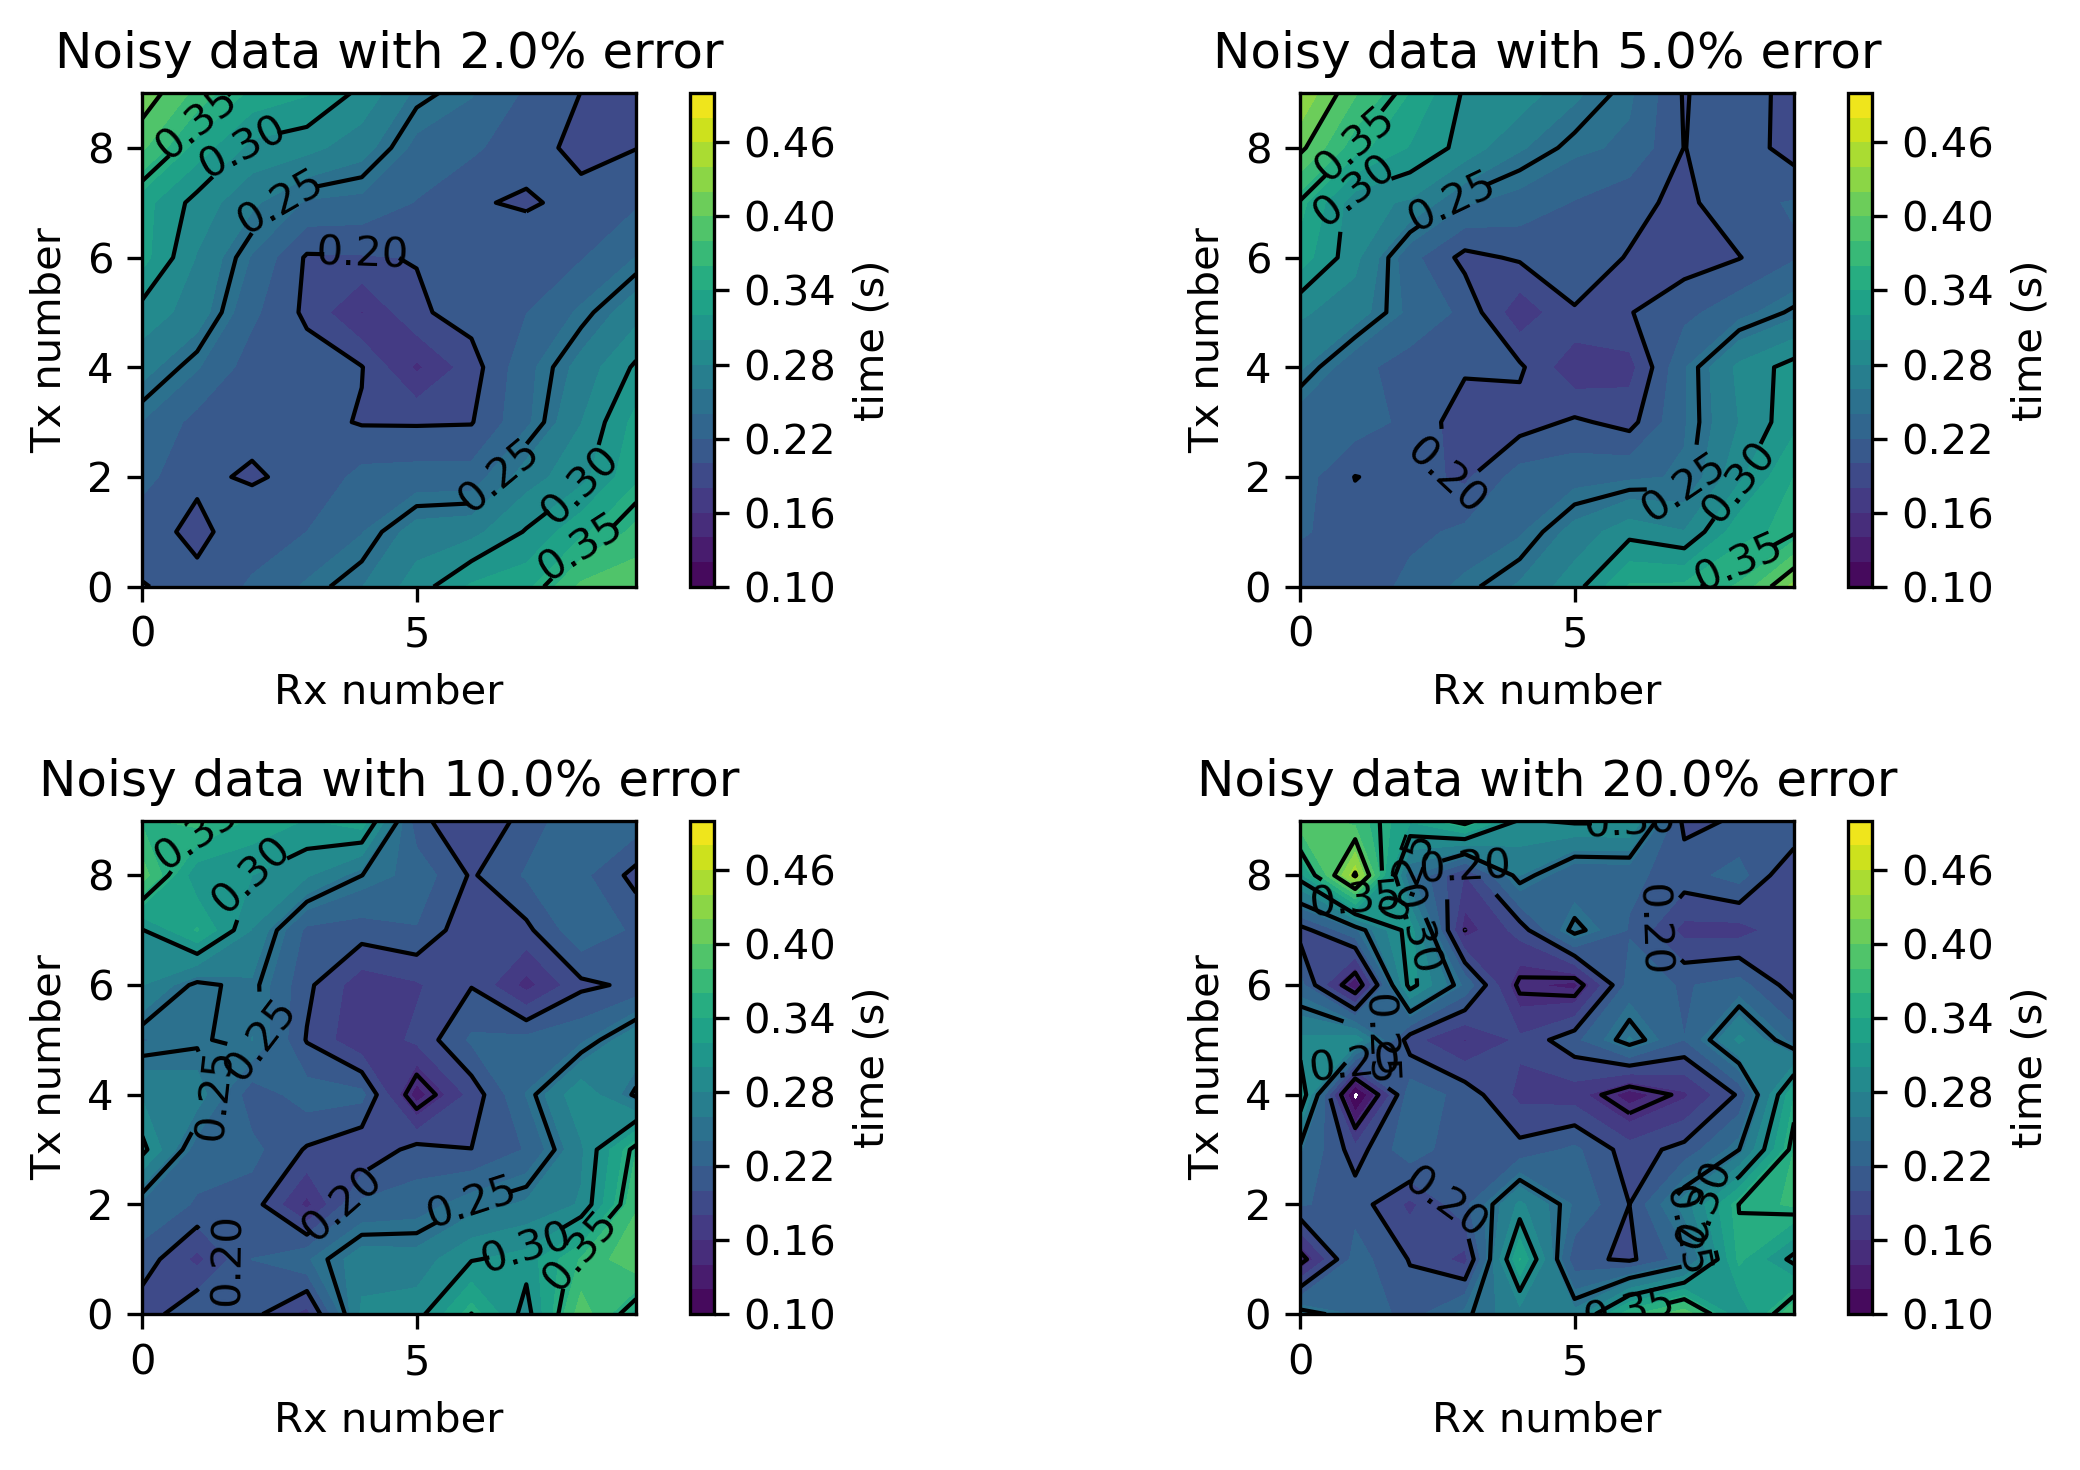

In [13]:
relative_error = [0.02,0.05,0.1,0.2]
fig, ax = plt.subplots(2, 2, figsize=(8, 5), dpi=300)
for i in range(4):
    noisy_data = clean_data + np.random.randn(len(clean_data)) * relative_error[i] * np.abs(clean_data)
    plot_model(ax.flatten()[i], noisy_data, f"Noisy data with {relative_error[i]*100}% error",contour=True)
plt.tight_layout()


# Q1.e
Next, we will move the target. Move it so that it is centered within the top 100m of the survey area and again plot the data with and without the block. At what noise levels would you now expect would be the maximum at which we could expect to see the target? Is this similar or different that if the block is in the center? Why?

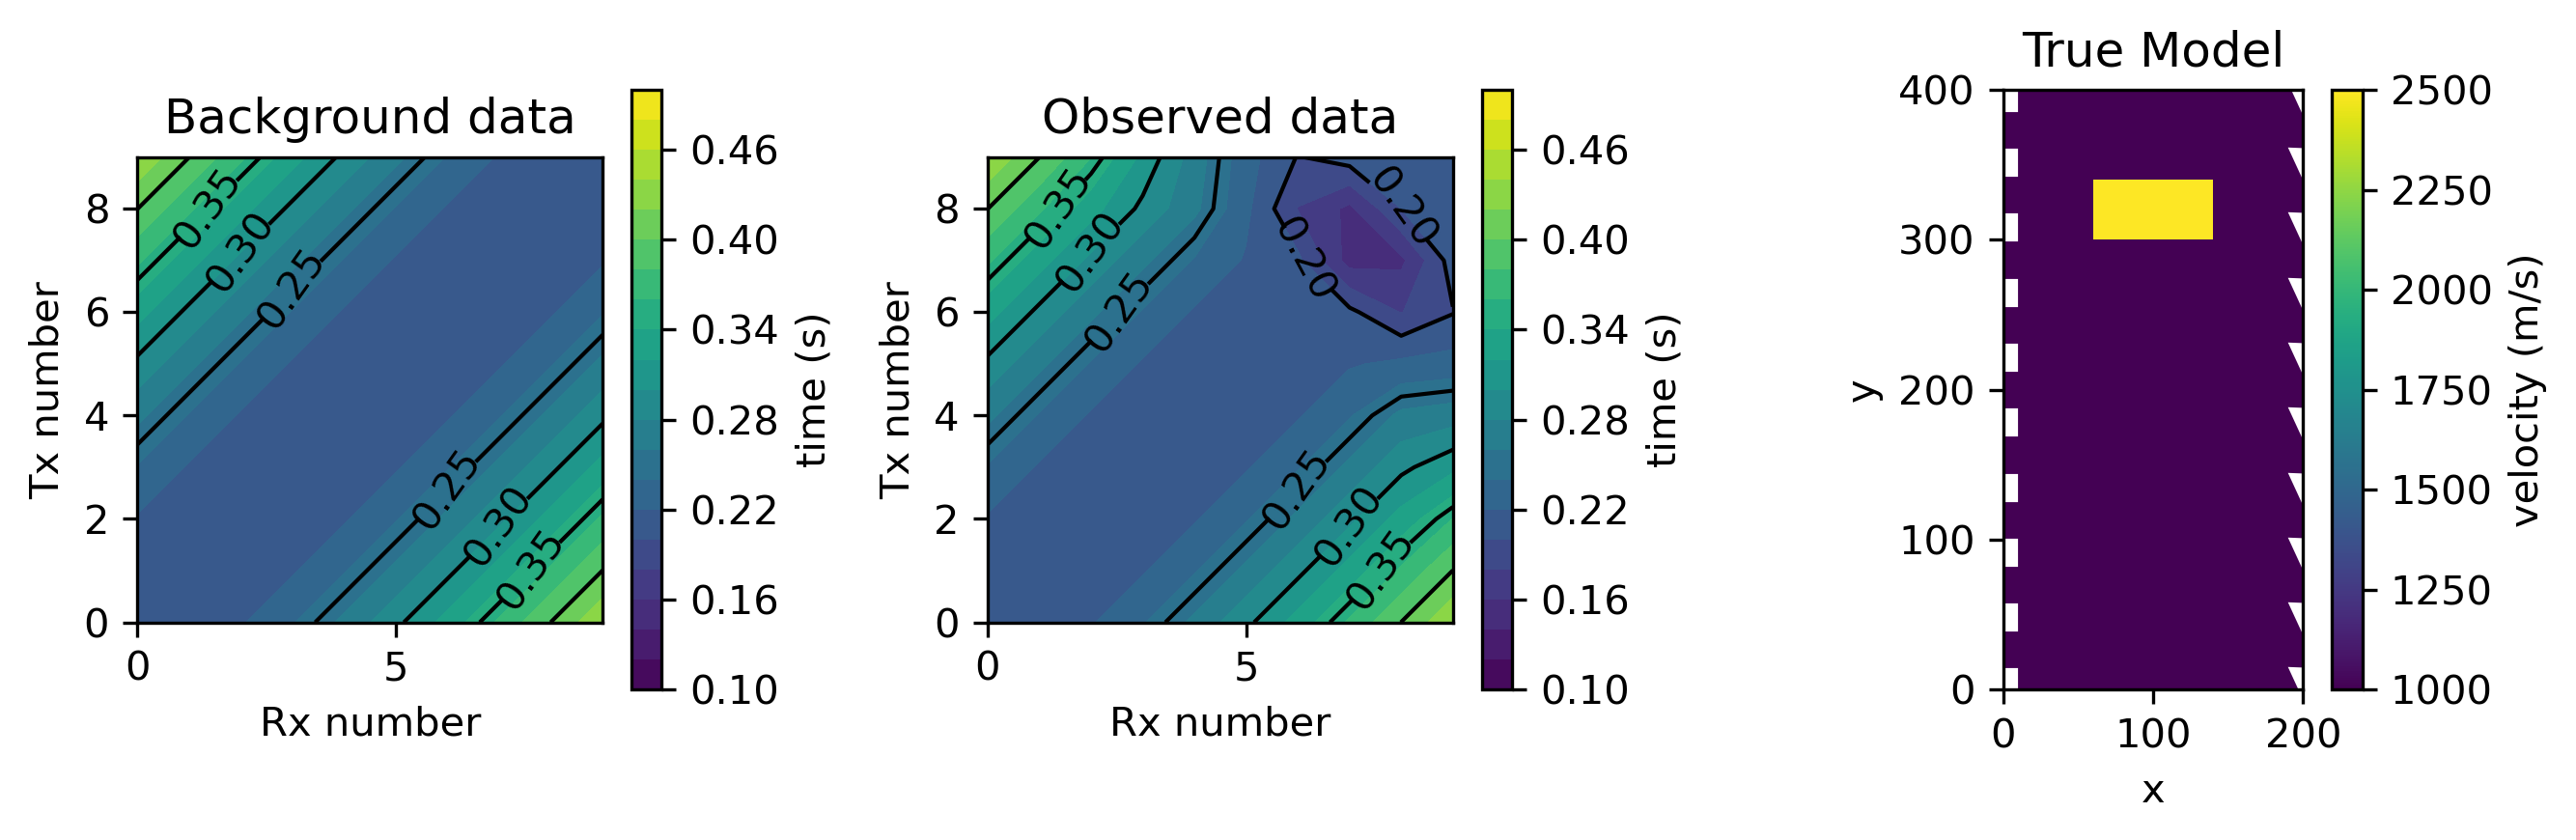

In [14]:
shifted_block_y = np.r_[300, 340]
shifted_velocity_model = v0*np.ones(mesh.n_cells)
shifted_velocity_model = add_block(shifted_velocity_model, block_x, shifted_block_y, v1)
shifted_slowness_model = 1/shifted_velocity_model

shifted_clean_data = simulation.dpred(shifted_slowness_model)
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
plot_model_survey(
    mesh, shifted_velocity_model, source_locations, receiver_locations,
    show_raypaths=False, ax = ax[2]
)
for i, dplot in enumerate([background_data, shifted_clean_data]):
    plot_model(ax[i], dplot, ["Background data", "Observed data"][i])
plt.tight_layout()


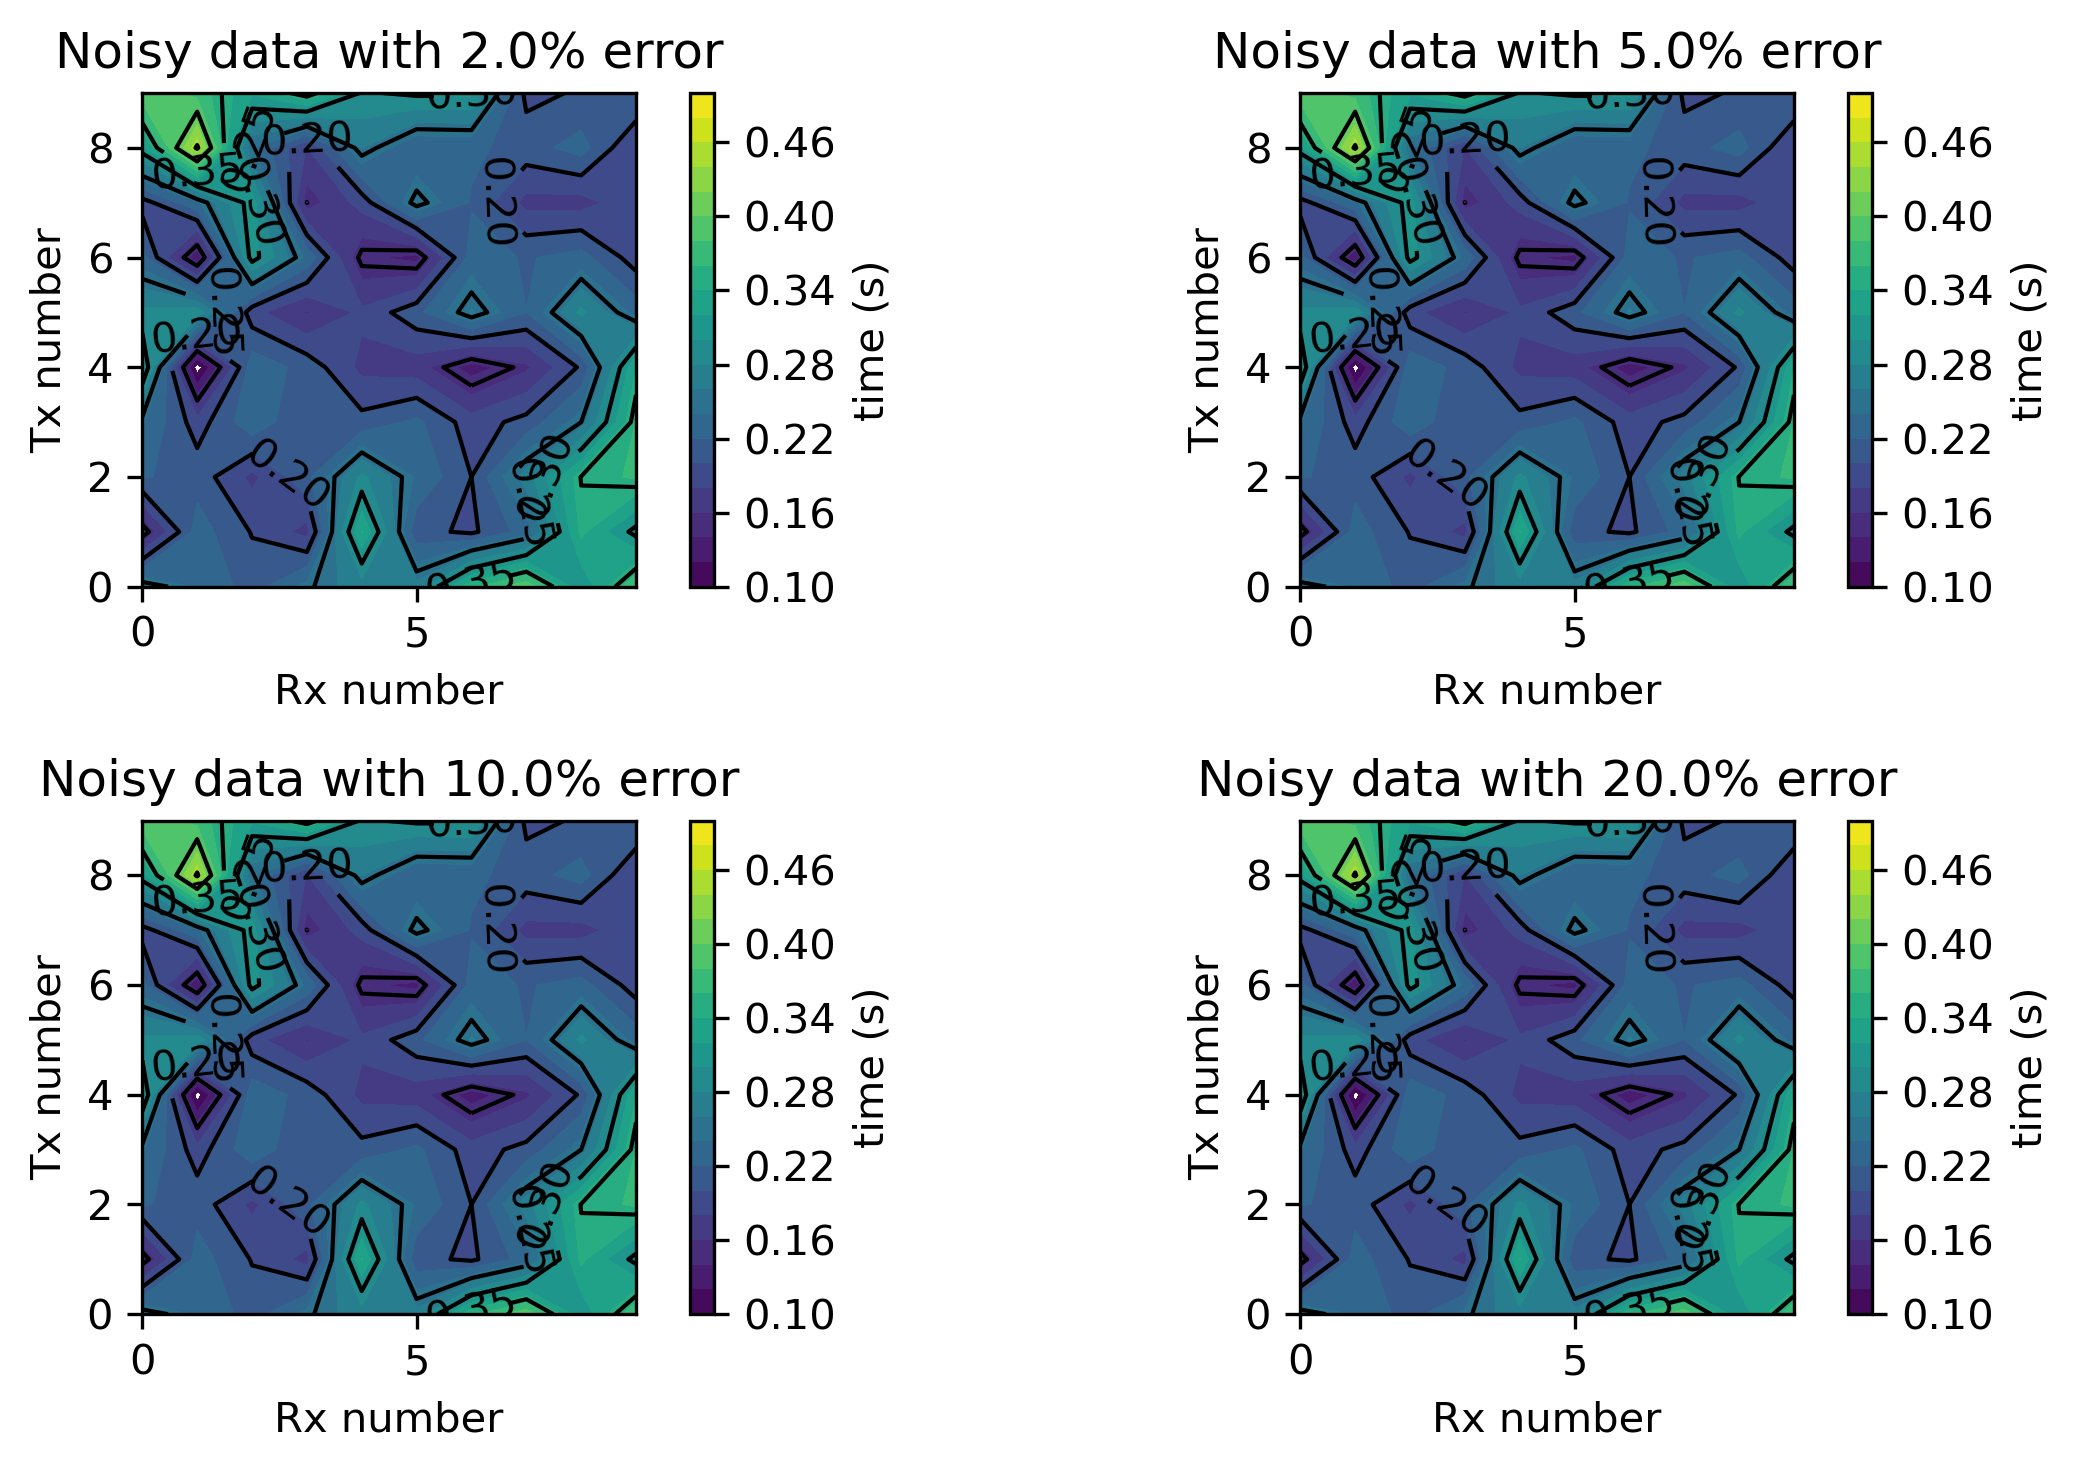

In [15]:
relative_error = [0.02,0.05,0.1,0.2]
fig, ax = plt.subplots(2, 2, figsize=(8, 5), dpi=300)
for i in range(4):
    shifted_noisy_data = shifted_clean_data + np.random.randn(len(clean_data)) * relative_error[i] * np.abs(clean_data)
    plot_model(ax.flatten()[i], noisy_data, f"Noisy data with {relative_error[i]*100}% error",contour=True)
plt.tight_layout()


# Q2
In this question, we will explore solving the inverse problem using a "smoothest model" approach. Position the block near the center of the domain and add noise at a level where you are still confident where we can detect the target in our data.

Q2.a) Start by setting up a "smoothest" model inversion. Using an accurate estimate of the uncertainties. Describe your setup. Generate plots of the Tikhonov curves. Select an iteration that adequately fits the data and show the observed and predicted data, and their difference. Finally plot the recovered model. Describe why you picked this model.

In [16]:
## set up the inversion
relative_error = 0.02
noisy_data = clean_data + np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
data_object = data.Data(tomo_survey, dobs=noisy_data, relative_error=relative_error)
dmis = data_misfit.L2DataMisfit(data_object, simulation)

In [17]:
# Set up the regularization
#smallness
alpha_s = 1/mesh.h[0][0]**2
#smoothness
alpha_x = 1
alpha_y = 1

reg_s = regularization.Smallness(mesh, reference_model=background_slowness_model)
reg_x = regularization.SmoothnessFirstOrder(mesh, orientation="x")
reg_y = regularization.SmoothnessFirstOrder(mesh, orientation="y")

reg = alpha_s * reg_s + alpha_x * reg_x + alpha_y * reg_y

In [35]:
opt = optimization.ProjectedGNCG(lower=0.0, maxIter=50)
invprob = inverse_problem.BaseInvProblem(dmis, reg, opt)
chifact=0.1
beta0_ratio=1e3
coolingFactor=2

save = directives.SaveOutputDictEveryIteration()
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
beta_schedule = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=1
)
# target = directives.TargetMisfit(chifact=chifact)
directives_list = [
    beta_estimate,
    beta_schedule,
    save
]

In [36]:
inv = inversion.BaseInversion(invprob, directives_list)
m0 = background_slowness_model
mopt = inv.run(m0)


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.18e+10  8.42e+02  0.00e+00  8.42e+02    3.68e+04      0              
   1  3.09e+10  8.34e+02  5.90e-11  8.36e+02    1.85e+04      0              
   2  1.54e+10  8.27e+02  2.33e-10  8.31e+02    1.87e+04      0   Skip BFGS  
   3  7.72e+09  8.13e+02  9.11e-10  8.20e+02    1.90e+04      0   Skip BFGS  
   4  3.86e+09  7.87e+02  3.48e-09  8.00e+02    1.96e+04      0   Skip BFGS  
   5  1.93e+09  7.38e+02  1.28e-08  7.63e+02    2.08e+04      0   Skip BFGS  
   6  9.65e+08  6.58e+02  4.35e-08  7.00e+02    2.31e+04      

In [37]:
def plot_tikhonov_curves(beta_values, phi_d, phi_m, phid_star=None, iteration=None, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12,3))
    
    ax[0].loglog(beta_values, phi_d)
    ax[1].loglog(beta_values, phi_m)
    ax[2].loglog(phi_d, phi_m)

    if phid_star is not None: 
        ax[0].loglog(beta_values, np.ones_like(beta_values) * phid_star, "--k")

    ax[0].set_ylabel("$\\phi_d$")
    ax[1].set_ylabel("$\\phi_m$")
    ax[2].set_ylabel("$\\phi_d$")
    ax[2].set_xlabel("$\\phi_m$")
    
    if iteration is not None: 
        ax[0].plot(beta_values[iteration], phi_d[iteration], "C3o")
        ax[1].plot(beta_values[iteration], phi_m[iteration], "C3o")
        ax[2].plot(phi_d[iteration], phi_m[iteration], "C3o")

    for a in ax[:2]:
        a.invert_xaxis()
        a.set_xlabel("$\\beta$")
    plt.tight_layout()
    
    return ax

In [38]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

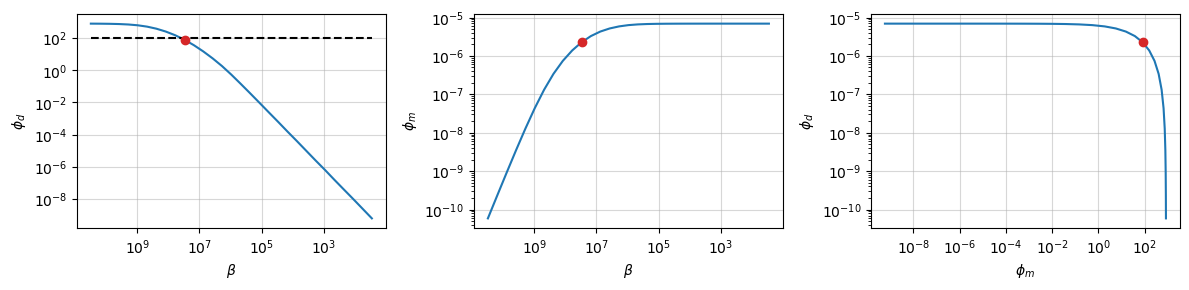

In [40]:
iteration = 10
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: title={'center': 'True Model'}, xlabel='x', ylabel='y'>

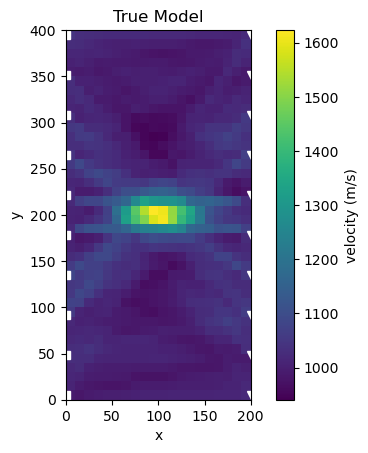

In [41]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,
)

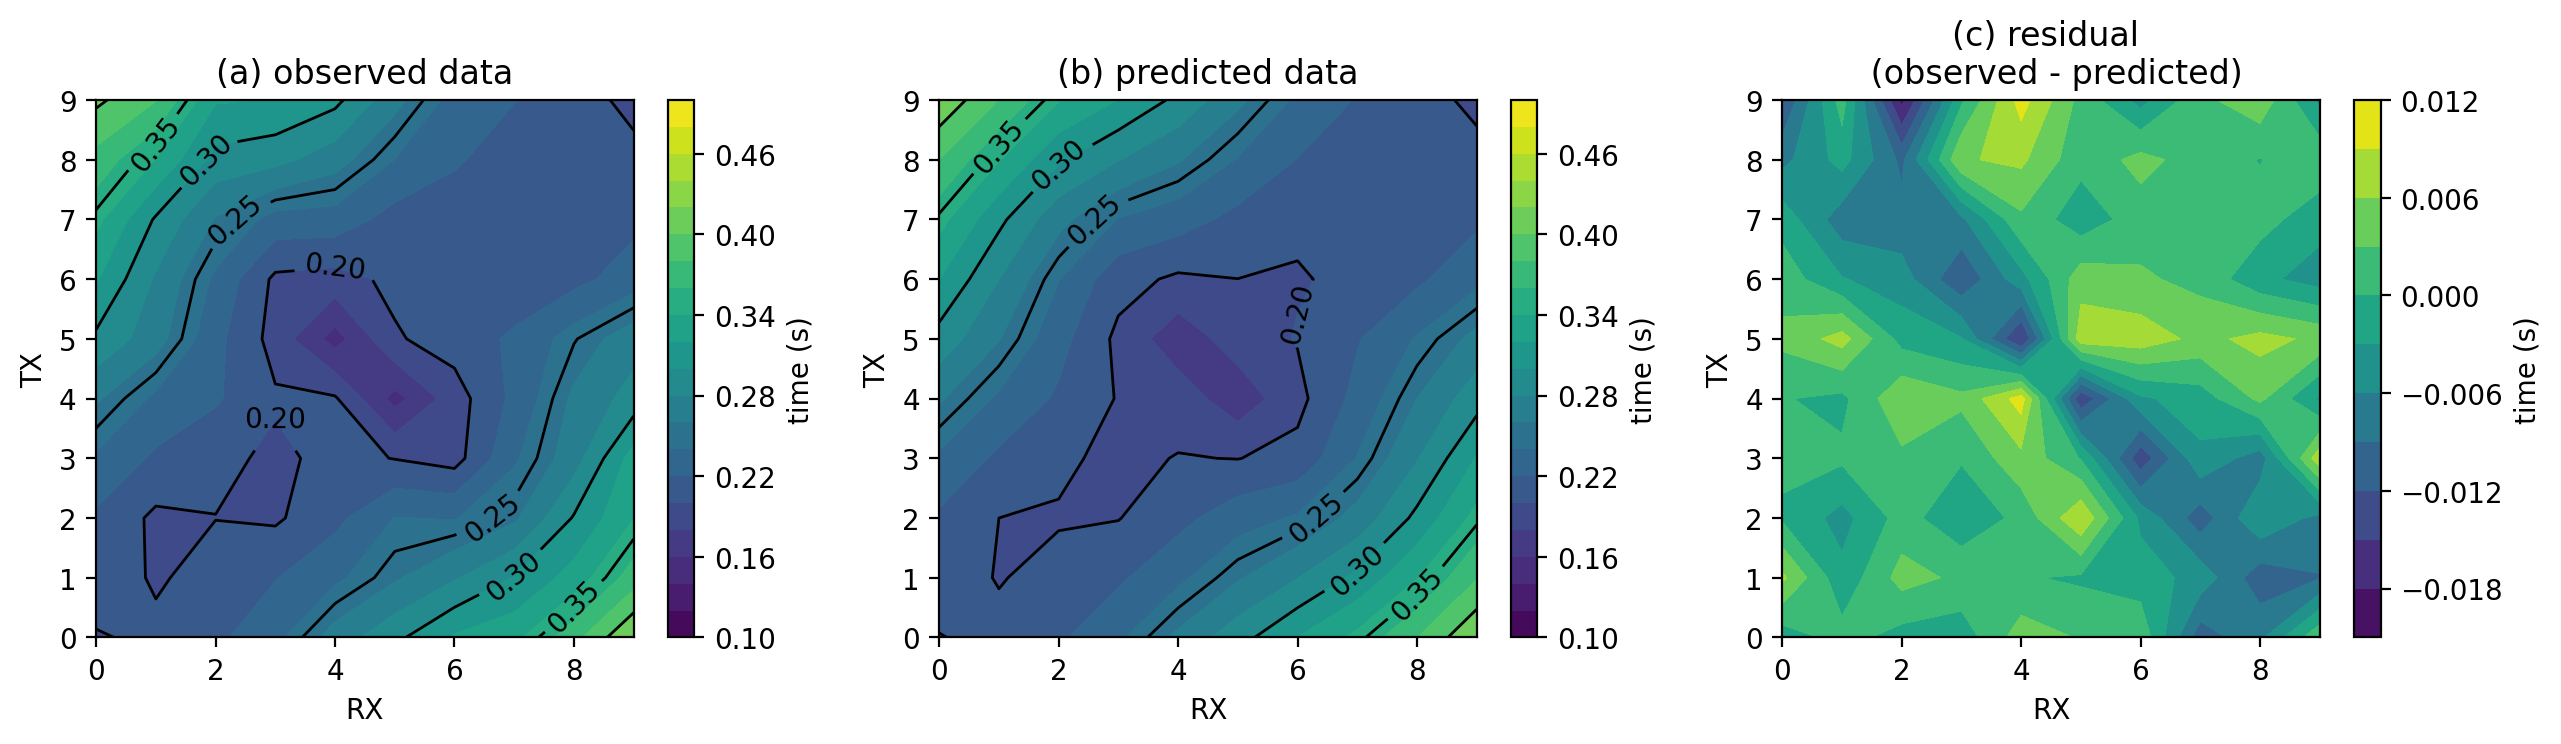

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=200)
dpred_i = simulation.dpred(models[iteration])

for i, dplot in enumerate([noisy_data, dpred_i, noisy_data-dpred_i]): 
    
    if i < 2: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))

        CS = ax[i].contour(
                dplot.reshape(n_src, n_src, order="F"), 
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax[i].clabel(CS, inline=True, fontsize=10)
    else: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=10))
    
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) observed data")
ax[1].set_title("(b) predicted data")
ax[2].set_title("(c) residual \n (observed - predicted)")
plt.tight_layout()